In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import strid
import matplotlib.pyplot as plt
import scipy.signal

# Generating data

In this notebook we generate the data used further in the example. A shear frame 9 floors is used in the example, and we assume Rayleigh damping, defined by 5% in the first and last mode. We generate data for two cases, a stocastic case and a combined stochastic-deterministic case.

The output is assumed to be accelerations at each floor together with white, zero mean, independent measurement noise.

## Stochastic case

The load (input) is stochastic and consists of zero mean independent white process noise applied to all floors

<IPython.core.display.Javascript object>


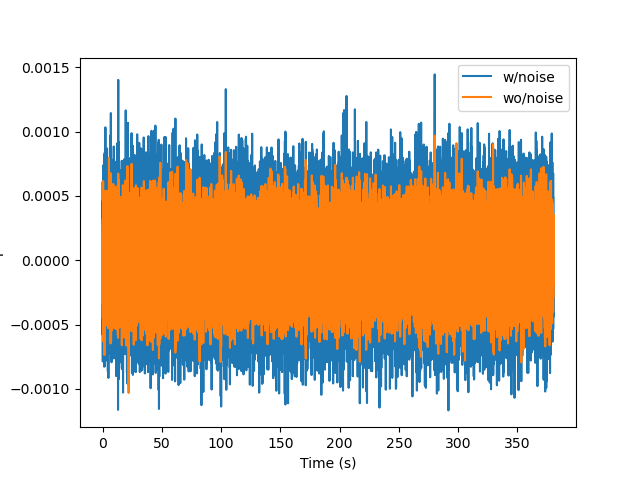

<IPython.core.display.Javascript object>


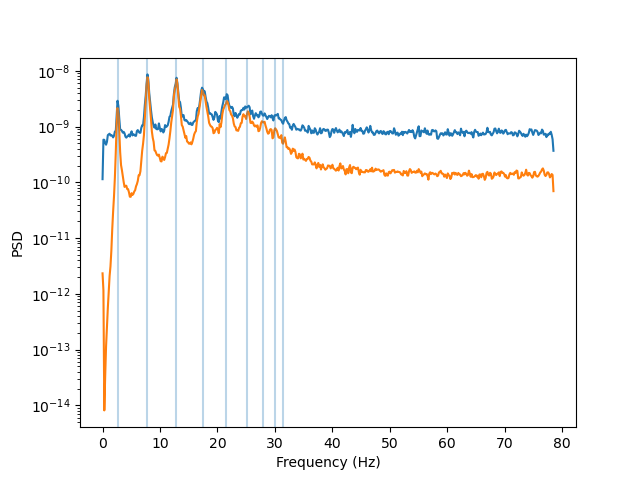

Text(0.5, 0, 'Frequency (Hz)')

In [3]:
# Create a shear frame
sf = strid.utils.ShearFrame(9, 1e3, 1e7)
sf.set_rayleigh_damping_matrix([sf.get_natural_frequency(1), sf.get_natural_frequency(sf.n)], [.05]*2)

# Determine the time discretization and period
Tmax = 1. / strid.w2f(sf.get_natural_frequency(1))
fmax = strid.w2f(sf.get_natural_frequency(sf.n))
T = 1000*Tmax
fs = 5 * fmax
t = np.arange(0., T, 1/fs)

# Define loads on system
## Unmeasureable: Stochastic loads on all floors (Process noise)
w = np.random.normal(size=(sf.n, t.size)) * 1e-1

## Load matrix, f
F = w.copy()

# Simulate response, accelerations at each floor measured
y0, _, _ = sf.simulate(t, F)

noise_std = y0.std()

# Add measurement noise
v = np.random.normal(size=y0.shape)*noise_std
y = y0 + v

plt.figure("Accelerations measured at top floor")
plt.plot(t, y[-1], label="w/noise")
plt.plot(t, y0[-1], label="wo/noise")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.figure("PSD of accelerations at top floor")
for yi in [y[-1], y0[-1]]:
    freqs, Gyy = scipy.signal.welch(yi, fs, nperseg=2**10)
    plt.semilogy(freqs, Gyy)
    

for n in range(1, 1+sf.n):
    plt.axvline(strid.w2f(sf.get_natural_frequency(n)), alpha=.3)
plt.ylabel('PSD')    
plt.xlabel('Frequency (Hz)')

In [5]:
true_frequencies = np.array([sf.get_natural_frequency(i)/(2*np.pi) for i in range(1, sf.n+1)])
true_damping = np.array([sf.get_rayleigh_damping_ratio(i) for i in range(1, sf.n+1)])
true_modeshapes = np.array([sf.get_mode_shape(i) for i in range(1, sf.n+1)])

np.savez("results/data-stochastic.npz", 
         y=y, fs=fs, 
         true_frequencies=true_frequencies,
         true_damping=true_damping,
         true_modeshapes=true_modeshapes
        )

# Combined deterministic stochastic case

In addition to the stochastic (unmeasureable) loading, a deterministic (measured) loading is applied to the structure. The load is assumed to be random applied to the top floor which goes from zero to twice the highest natural frequency of the shear frame 

<IPython.core.display.Javascript object>


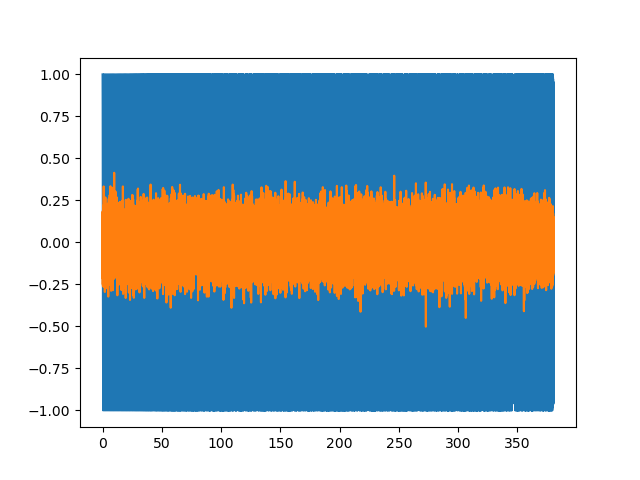

<IPython.core.display.Javascript object>


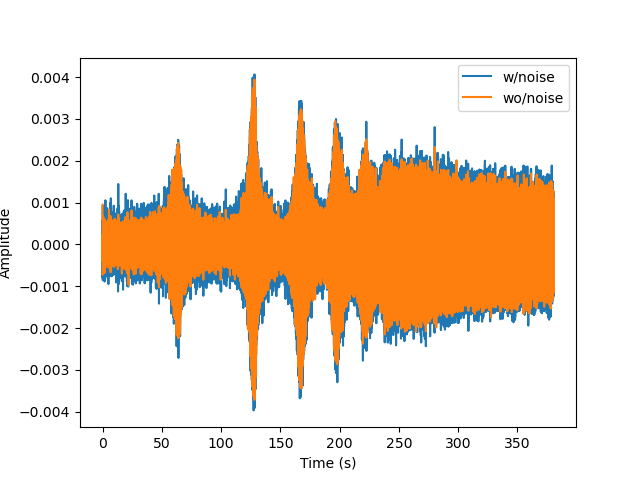

<IPython.core.display.Javascript object>


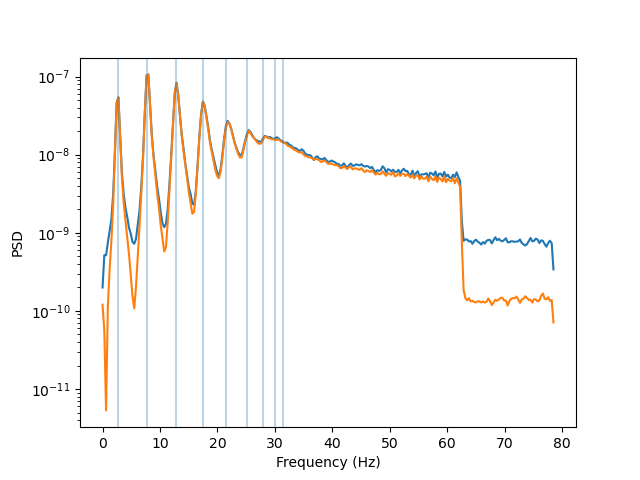

Text(0.5, 0, 'Frequency (Hz)')

In [8]:
u = scipy.signal.chirp(t, 1., T, fmax*2, method='quadratic').reshape(1, -1)

## Load matrix, f
F = w.copy() # Stochastic loading
F[-1] += u[0] # Deterministic loading to top floor

# Simulate response, accelerations at each floor measured
y0, _, _ = sf.simulate(t, F)

# Add measurement noise
y = y0 + v

plt.figure("Loads")
plt.plot(t, u[0], label="Deterministic")
plt.plot(t, w[-1], label="Stochastic - top floor")

plt.figure("Accelerations at top floor - Combined")
plt.plot(t, y[-1], label="w/noise")
plt.plot(t, y0[-1], label="wo/noise")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.figure("PSD of accelerations at top floor - Combined")
for yi in [y[-1], y0[-1],]:
    freqs, Gyy = scipy.signal.welch(yi, fs, nperseg=2**9)
    plt.semilogy(freqs, Gyy)
    

for n in range(1, 1+sf.n):
    plt.axvline(strid.w2f(sf.get_natural_frequency(n)), alpha=.3)
plt.ylabel('PSD')    
plt.xlabel('Frequency (Hz)')

In [9]:
np.savez("results/data-combined.npz", 
         u=u, y=y, fs=fs, 
         true_frequencies=true_frequencies,
         true_damping=true_damping,
         true_modeshapes=true_modeshapes
        )